# DTSA-5511,  Week 3: CNN Cancer Detection Kaggle Mini-Project
### September 25, 2023


## Histopathologic Cancer Detection using Convolutional Neural Networks
https://www.kaggle.com/c/histopathologic-cancer-detection/overview


This jupyter notebok is uploaded to https://github.com/daisukexp/dtsa5511_week3

# Step 1 : Brief description of the problem and data
For the assignment of week 3, we have a mini-project where we will participate in the Kaggle competition: Histopathologic Cancer Detection. This competition presents a binary image classification problem, where our objective is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

The dataset is comprised of 220,025 TIFF images, each with dimensions of 96x96x3. These images are labeled with binary values: '1' indicates the presence of cancer, while '0' denotes its absence. Additionally, there are 57,458 unlabeled test images.

We will develop CNN models to classify the test images, and the performance of these models will be assessed based on their accuracy scores when submitted to the competition.

In [109]:
import sys
import platform
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import cv2
import gc
import math
import json
import visualkeras
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential



train_on_gpu = True

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

In [110]:
sys.version

'3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]'

In [111]:
tf.__version__

'2.10.1'

In [112]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [113]:
train_on_gpu = tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
if train_on_gpu & train_on_gpu:
    print("GPU is available.")
    !nvidia-smi
else:
    print("Training on CPU.")

GPU is available.
Mon Sep 25 14:09:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   43C    P5              22W / 200W |  11662MiB / 12282MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

# Step 2 : Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data
The dataset is derived from the PCam dataset and has already been cleaned.

In [119]:
train_path = 'data/histopathologic-cancer-detection/train'
test_path = 'data/histopathologic-cancer-detection/test'
labels_data = 'data/histopathologic-cancer-detection/train_labels.csv'

df_train_labels = pd.read_csv(labels_data)
df_train_labels['image_file'] = df_train_labels['id'].apply(lambda x: f'{x}.tif')
df_train_labels

,id,label,image_file
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,d4b854fe38b07fe2831ad73892b3cec877689576.tif
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,f129691c13433f66e1e0671ff1fe80944816f5a2.tif


label
0    130908
1     89117
Name: count, dtype: int64 

Label Total :  220025


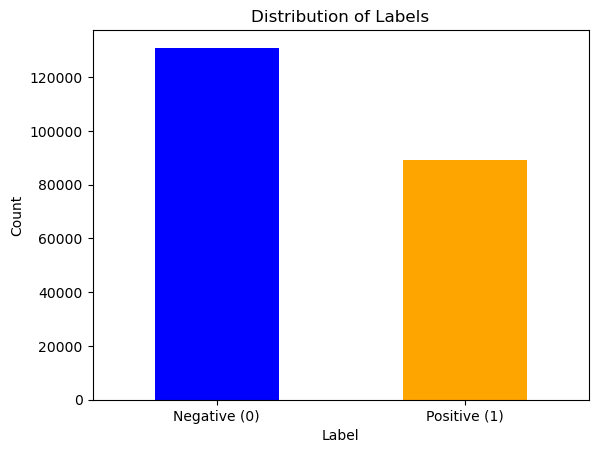

In [120]:
label_counts = df_train_labels['label'].value_counts()
print(label_counts, '\n')
print('Label Total : ', df_train_labels.shape[0])

label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative (0)', 'Positive (1)'], rotation = 0)
plt.show()

In [121]:
n_train, n_test = len(os.listdir(train_path)), len(os.listdir(test_path))
print(f'Number of Training Images = {n_train}')
print(f'Number of Test Images     = {n_test}\n')

Number of Training Images = 220025
Number of Test Images     = 57458



The provided training data contains a total of 220,025 images, with 130,908 being cancer negative and 89,117 being cancer positive. The test data includes 57,458 unlabeled images.

In [122]:
def display_images(samples, title, images_per_row = 5):
    num_images = len(samples)
    num_rows = math.ceil(num_images / images_per_row)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, images_per_row * num_rows))
    
    if num_rows == 1:
        axes = np.expand_dims(axes, axis = 0)
    
    for idx, img_path in enumerate(samples):
        row = idx // images_per_row
        col = idx % images_per_row
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    for idx in range(num_images, num_rows * images_per_row):
        row = idx // images_per_row
        col = idx % images_per_row
        fig.delaxes(axes[row, col])
        
    plt.suptitle(title, fontsize = 20)
    plt.show()

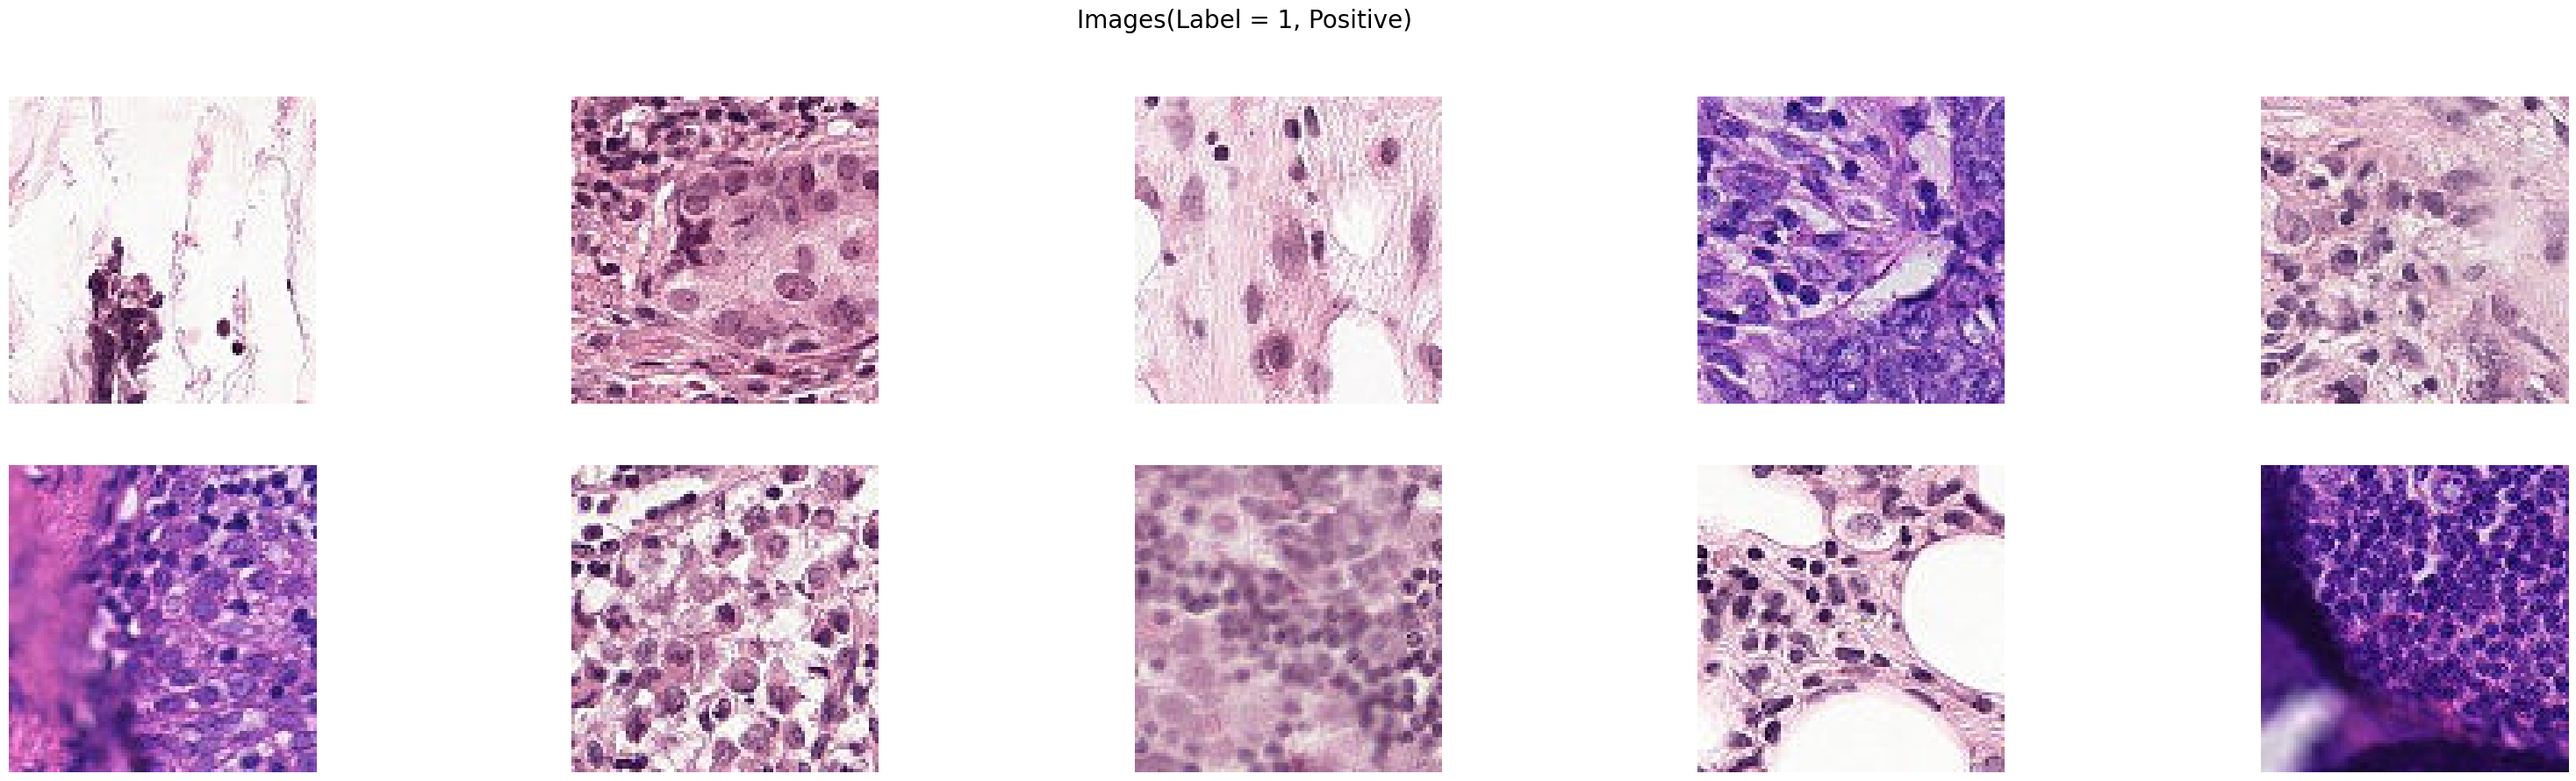

In [123]:
# Positive samples
positive_samples = df_train_labels[df_train_labels['label'] == 1]['id'].head(10).apply(lambda x: f'{train_path}/{x}.tif').tolist()
display_images(positive_samples, "Images(Label = 1, Positive)")

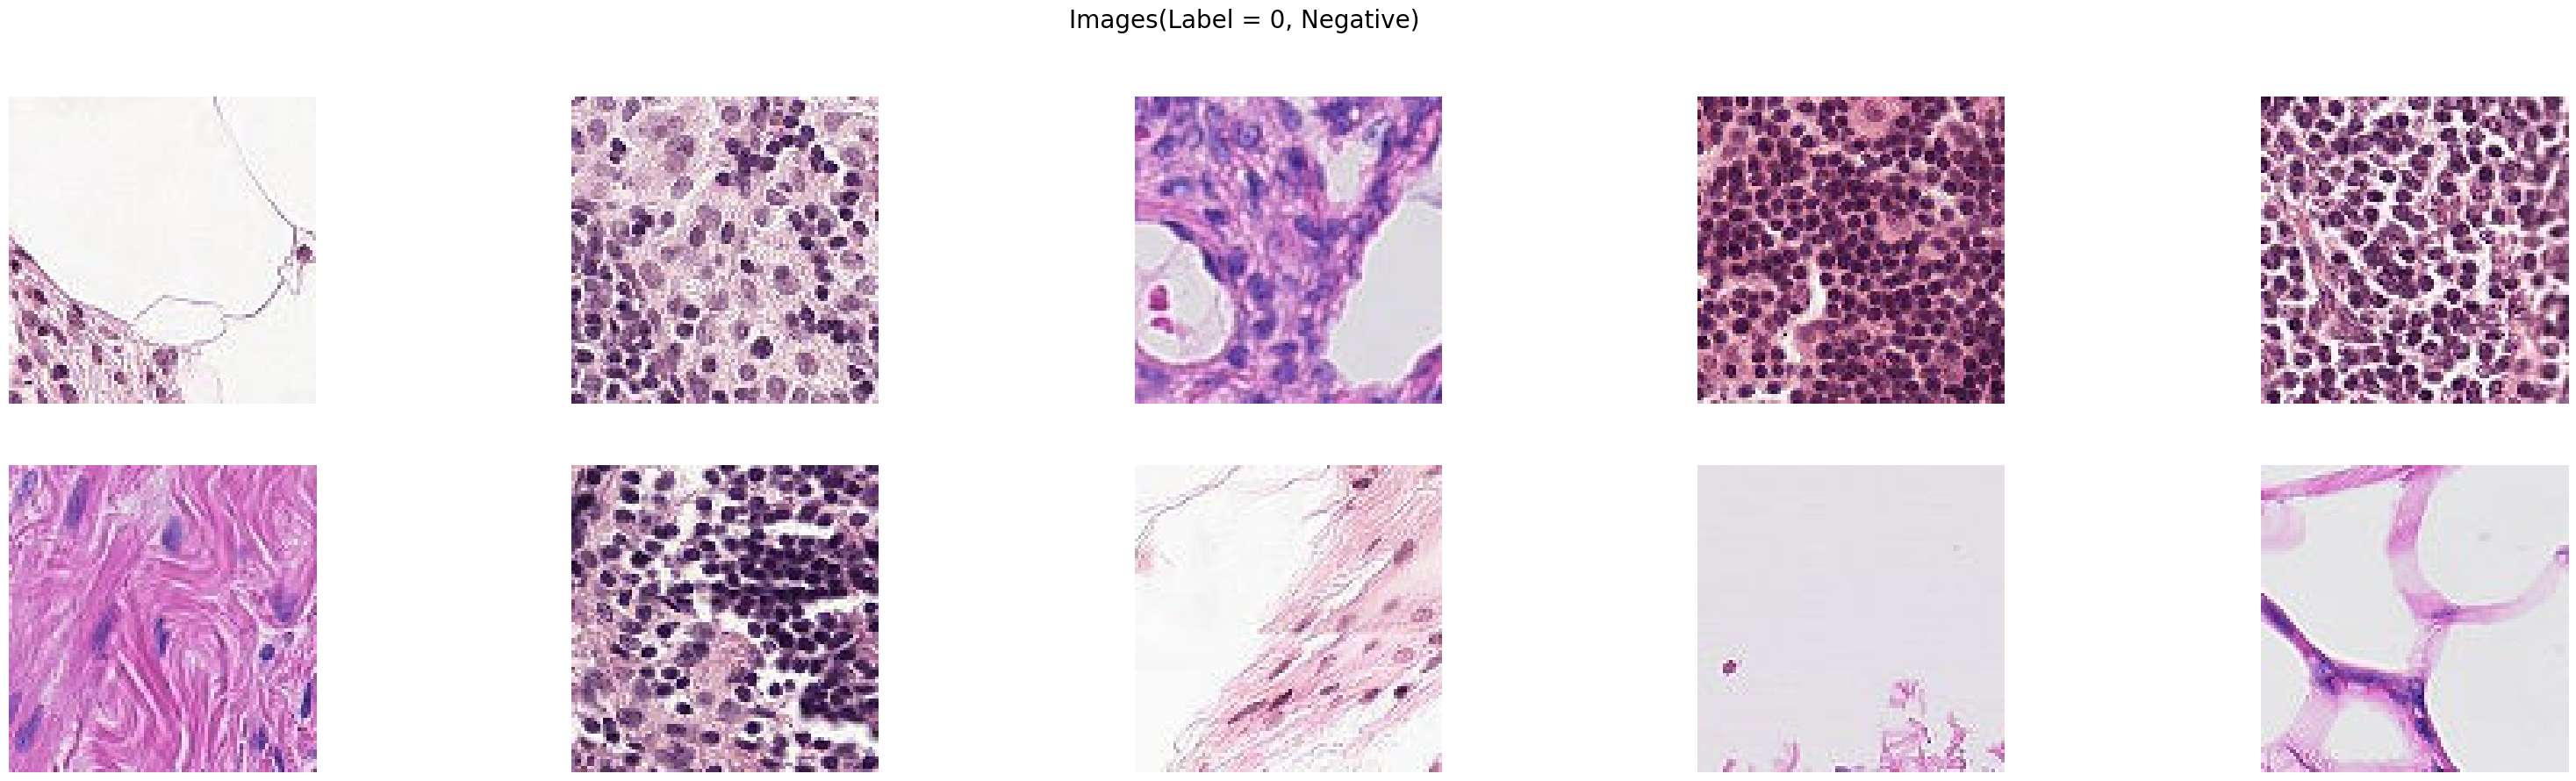

In [124]:
# Negative samples
negative_samples = df_train_labels[df_train_labels['label'] == 0]['id'].head(10).apply(lambda x: f'{train_path}/{x}.tif').tolist()
display_images(negative_samples, "Images(Label = 0, Negative)")

The plot displays 10 images each for Positive and Negative cases. The distinction between negative and positive cases is not immediately discernible to the naked eye, making it intriguing to see how well the predictive model can classify them.

# Step 3 : Model Architecutre

## 3.1 Model selection
Several models are accessible via TensorFlow for solving image classification problems. In this project, we select three different models to compare their performance on the task of identifying metastatic cancer from histopathologic scans.
### Standard CNN model

The Standard Convolutional Neural Network (CNN) model is a foundational model in the field of computer vision. It uses convolutional layers to filter input images in small chunks and can detect hierarchical patterns using multiple layers. We use a basic architecture consisting of convolutional layers, pooling layers, and fully connected layers to classify the images into cancerous or non-cancerous.

### EfficientNet

EfficientNet is a family of models that were developed with the aim of scaling model size in a more principled manner. It uses a combination of depthwise separable convolutions and compound scaling to achieve high accuracy with fewer parameters compared to other models. For this project, we employed EfficientNet, trained from scratch, without leveraging external pre-trained models. This approach allows the model to learn features solely from the given histopathologic cancer detection dataset, ensuring that the representations learned are task-specific.


### EfficientNet with parameter tuning

This variation of EfficientNet has been further optimized through parameter tuning. To mitigate overfitting and improve the model's ability to generalize, kernel regularization (specifically L2 regularization with a coefficient of 0.01) is applied to the Dense layers of the model. Moreover, Early Stopping is utilized to monitor the performance of the model on the validation data and halt the training process once no improvement is observed. This not only saves computational resources but also ensures the model does not overtrain, maintaining a balance between bias and variance.



Through comparative analysis of these models, we aim to discern which model is most effective for detecting histopathologic cancer in the provided dataset, while considering the constraints and specificities of our project.

### 3.1.1 Standard CNN model

To begin, we construct a standard Convolutional Neural Network (CNN) with a commonly used architecture, referring to the TensorFlow tutorial, as shown in the following link.

https://www.tensorflow.org/tutorials/images/cnn

#### Model Description
This model consists of a series of Conv2D layers, each followed by a MaxPooling2D layer. These layers are used to extract hierarchical features from the input images. The Flatten layer reshapes the 2D matrix data to a vector and the Dense layers make predictions. A Dropout layer is also added to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time. The final layer of the model is a Dense layer with a single unit and a 'sigmoid' activation, The sigmoid activation function, also known as the logistic function, is used in the output layer of the model for binary classification problems. It transforms its input value to an output value ranging between 0 and 1, which can be interpreted as the probability of belonging to the positive class in binary classification.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)     

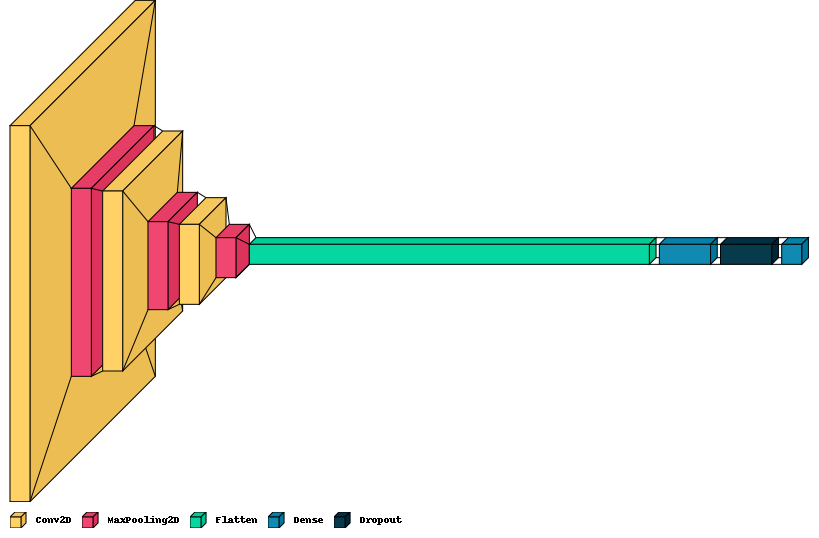

In [125]:
model_std = Sequential()

# Create the convolutional base using, Conv2D and MaxPooling2D
model_std.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_std.add(MaxPooling2D(pool_size=(2, 2)))

model_std.add(Conv2D(64, (3, 3), activation='relu'))
model_std.add(MaxPooling2D(pool_size=(2, 2)))

model_std.add(Conv2D(128, (3, 3), activation='relu'))
model_std.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
model_std.add(Flatten())
model_std.add(Dense(512, activation='relu'))
model_std.add(Dropout(0.5))
model_std.add(Dense(1, activation='sigmoid'))

model_std.summary()
visualkeras.layered_view(model_std, legend=True)

The Adam optimizer with a learning rate of 0.0001 is used, and binary cross-entropy is the chosen loss function due to the binary nature of our classification task. The model is trained with a batch size of 250 for 10 epochs. The dataset is split into training and validation subsets, with images being rescaled by 1/255.

In [126]:
optimizer = Adam(learning_rate=0.0001)
model_std.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
batch_size = 250 # using too large a batch size can lead to out-of-memory errors and slow down training.
train_epochs = 10 # Train epochs influences model performance, a bigger value does not always showes better performance

In [95]:
tf.keras.backend.clear_session()

In [128]:
train_datagen = ImageDataGenerator(rescale = 1./255.)

df_train_labels['label'] = df_train_labels['label'].astype(str) 
df_train, df_val = train_test_split(df_train_labels, test_size = 0.2, random_state = 123)

train_gen = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    x_col = 'image_file',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = batch_size
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = train_path,
    x_col = 'image_file',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [129]:
# Training the model
history_std = model_std.fit(train_gen, validation_data = val_gen, epochs = train_epochs)

Epoch 1/10
705/705 [==============================] - 79s 111ms/step - loss: 0.4680 - accuracy: 0.7824 - val_loss: 0.4350 - val_accuracy: 0.8039
Epoch 2/10
705/705 [==============================] - 76s 108ms/step - loss: 0.4208 - accuracy: 0.8114 - val_loss: 0.3996 - val_accuracy: 0.8228
Epoch 3/10
705/705 [==============================] - 76s 108ms/step - loss: 0.3887 - accuracy: 0.8290 - val_loss: 0.3658 - val_accuracy: 0.8419
Epoch 4/10
705/705 [==============================] - 77s 108ms/step - loss: 0.3644 - accuracy: 0.8423 - val_loss: 0.3713 - val_accuracy: 0.8355
Epoch 5/10
705/705 [==============================] - 465s 660ms/step - loss: 0.3415 - accuracy: 0.8529 - val_loss: 0.3238 - val_accuracy: 0.8633
Epoch 6/10
705/705 [==============================] - 458s 649ms/step - loss: 0.3242 - accuracy: 0.8608 - val_loss: 0.3221 - val_accuracy: 0.8597
Epoch 7/10
705/705 [==============================] - 75s 106ms/step - loss: 0.3082 - accuracy: 0.8692 - val_loss: 0.3010 - val_

### 3.2.1 EfficientNet

EfficientNet is a model designed to scale in a more structured manner compared to previous models, ensuring better performance and efficiency. It uses compound scaling to jointly scale up the depth, width, and resolution of the network.
- A Dense layer with 512 units and ReLU activation function for introducing non-linearity.
- A Dropout layer with a dropout rate of 0.5 to prevent overfitting by reducing over-dependence on specific neurons.
- The final Dense layer with a single unit and a sigmoid activation function for binary classification, where the output represents the probability that the input image is cancerous.

In [133]:
# Load EfficientNet with no weights
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights=None, pooling='avg')

model_en = Sequential([
    base_model, 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [134]:
optimizer = Adam(learning_rate=0.0001)
model_en.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
# Training the model
history_en = model_en.fit(train_gen, validation_data = val_gen, epochs = train_epochs)

Epoch 1/10
705/705 [==============================] - 122s 168ms/step - loss: 0.4680 - accuracy: 0.7824 - val_loss: 2.0626 - val_accuracy: 0.4460
Epoch 2/10
705/705 [==============================] - 119s 168ms/step - loss: 0.3879 - accuracy: 0.8297 - val_loss: 0.4116 - val_accuracy: 0.8173
Epoch 3/10
705/705 [==============================] - 118s 168ms/step - loss: 0.3521 - accuracy: 0.8480 - val_loss: 0.4252 - val_accuracy: 0.8118
Epoch 4/10
705/705 [==============================] - 118s 167ms/step - loss: 0.3232 - accuracy: 0.8617 - val_loss: 0.3440 - val_accuracy: 0.8520
Epoch 5/10
705/705 [==============================] - 118s 167ms/step - loss: 0.2942 - accuracy: 0.8757 - val_loss: 0.3825 - val_accuracy: 0.8375
Epoch 6/10
705/705 [==============================] - 119s 169ms/step - loss: 0.2679 - accuracy: 0.8881 - val_loss: 0.3317 - val_accuracy: 0.8600
Epoch 7/10
705/705 [==============================] - 118s 167ms/step - loss: 0.2357 - accuracy: 0.9031 - val_loss: 0.3863 -

### 3.3.1 EfficientNet with paramter tuning

Further enhance the EfficientNet model by incorporating parameter tuning techniques aimed at improving the model's generalization capability and preventing overfitting.

In this tuned model, we use the same EfficientNetB0 architecture as the base model, we add L2 regularization in the Dense layer with a regularization strength of 0.01.
L2 regularization is applied to the weights of the neurons and helps in preventing the weights from becoming too large, which can lead to overfitting. It adds a penalty equivalent to the square of the magnitude of the weights to the loss function, encouraging the model to learn the underlying patterns in the data rather than memorizing the training data.

EarlyStopping callback is employed during training. Early stopping monitors the validation loss (val_loss) and will stop the training process if there is no improvement in the monitored metric after a specified number of epochs, defined by the patience parameter. In this case, training will stop if there is no improvement in validation loss after 4 epochs which delived from https://keras.io/examples/nlp/active_learning_review_classification/. This callback also restores the model weights from the epoch with the best observed validation loss, ensuring the model does not retain weights that may have led to overfitting.

In [141]:
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights=None, pooling='avg')

model_en_tune = Sequential([
    base_model, 
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_en_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history_en_tune = model_en_tune.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, 
    callbacks=[early_stopping]
)

Epoch 1/50
705/705 [==============================] - 124s 170ms/step - loss: 0.5721 - accuracy: 0.8440 - val_loss: 2.4442 - val_accuracy: 0.4283
Epoch 2/50
705/705 [==============================] - 121s 171ms/step - loss: 0.2769 - accuracy: 0.8908 - val_loss: 1.2169 - val_accuracy: 0.7392
Epoch 3/50
705/705 [==============================] - 119s 168ms/step - loss: 0.2259 - accuracy: 0.9138 - val_loss: 0.5442 - val_accuracy: 0.7642
Epoch 4/50
705/705 [==============================] - 119s 168ms/step - loss: 0.1913 - accuracy: 0.9290 - val_loss: 0.4462 - val_accuracy: 0.8457
Epoch 5/50
705/705 [==============================] - 118s 167ms/step - loss: 0.1681 - accuracy: 0.9386 - val_loss: 0.3711 - val_accuracy: 0.8759
Epoch 6/50
705/705 [==============================] - 486s 690ms/step - loss: 0.1461 - accuracy: 0.9470 - val_loss: 0.6514 - val_accuracy: 0.8032
Epoch 7/50
705/705 [==============================] - 456s 646ms/step - loss: 0.1269 - accuracy: 0.9542 - val_loss: 0.4782 -

# Step 4 : Results and Analysis

In this step, we analyze the performance of the three different models we have trained: the Standard CNN model, EfficientNet, and EfficientNet with parameter tuning. Each model was trained and then used to predict classifications on the test data, with the results submitted to Kaggle for evaluation.

### Helper functions

Print out metrics of the model

In [87]:
def model_metrics(model):
    # Calculate the number of steps per epoch for validation data
    val_steps = np.ceil(len(val_gen.classes) / batch_size)

    # Predict class probabilities
    val_predictions_prob = model.predict(val_gen, steps=val_steps)

    # Convert probabilities to binary labels
    threshold = 0.5
    val_predictions = (val_predictions_prob > threshold).astype(int).flatten()

    # True labels
    val_true = val_gen.classes[:len(val_predictions)]

    # Calculate Metrics
    accuracy = accuracy_score(val_true, val_predictions)
    precision = precision_score(val_true, val_predictions)
    recall = recall_score(val_true, val_predictions)
    f1 = f1_score(val_true, val_predictions)
    roc_auc = roc_auc_score(val_true, val_predictions_prob)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

Plot accuracy and loss

In [88]:
def plot_history(history):
    # Extract accuracy from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract the number of epochs
    epochs = list(range(0, len(acc) + 1))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs) 
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs) 
    plt.legend()

    plt.show()

Predict test dataset

In [89]:
df_test = pd.DataFrame({'id':os.listdir(test_path)})
test_datagen = ImageDataGenerator(rescale = 1./255.).flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    x_col = 'id', 
    y_col = None,
    target_size = (96, 96),
    batch_size = 100,
    shuffle = False,
    class_mode = None)

Found 57458 validated image filenames.


In [90]:
def predict_test(model, file_submit):
    # predict output using the test images on our model
    predictions = model.predict(test_datagen)
    predictions_result = np.transpose(predictions)[0]

    # remove the file extension in the id column
    df_test = pd.DataFrame({'id':os.listdir(test_path)})
    df_test['id'] = df_test['id'].apply(lambda x: x.split('.')[0])

    # fill the prediction in the label column
    df_test['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions_result))

    # write the csv file
    df_test.to_csv(file_submit, index=False)

## 4.1 Standard CNN

In [130]:
model_metrics(model_std)

177/177 [==============================] - 15s 86ms/step
Accuracy: 0.5248494489262584
Precision: 0.4065119083509195
Recall: 0.3785938903863432
F1 Score: 0.3920565231297066
ROC-AUC: 0.5017321285768235


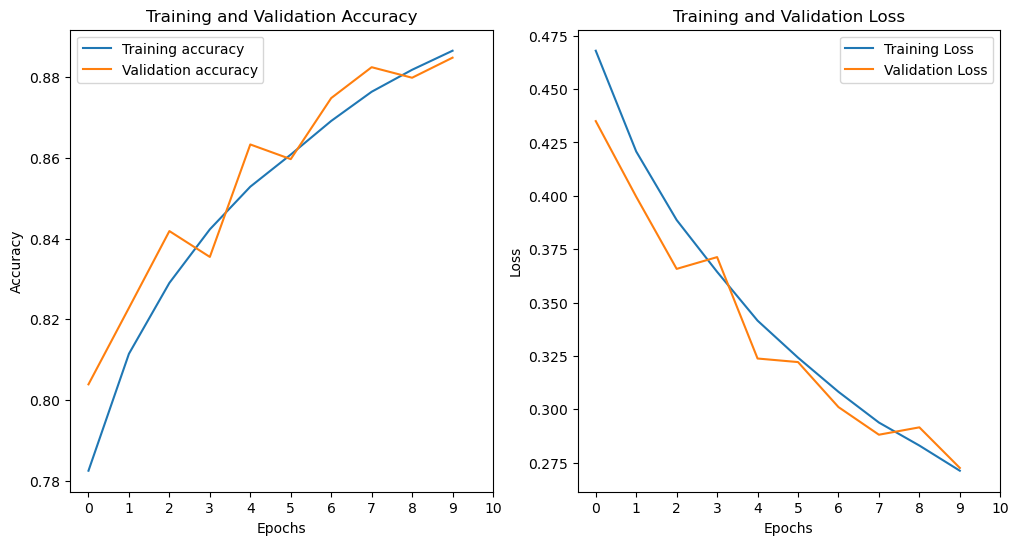

In [131]:
plot_history(history_std)

In [147]:
predict_test(model_std, 'data/my_submission_seq_epochs_10.csv')

575/575 [==============================] - 20s 35ms/step


Kaggle score is 0.7676.


The Standard CNN model, with its simple architecture, managed to achieve a moderate performance. However, the metrics indicate that there is room for improvement, especially in terms of the precision, recall, and F1 score.

Training and Validation:
The model underwent 10 epochs of training, with the training and validation losses and accuracies recorded at each epoch. The training accuracy improved over the epochs, reaching up to 
0.8866
0.8866 while the validation accuracy also showed improvement, reaching up to 
0.8849
0.8849.

## 4.2 EfficientNet

In [139]:
model_metrics(model_en)

177/177 [==============================] - 16s 88ms/step
Accuracy: 0.5204408589932962
Precision: 0.4051143235615965
Recall: 0.39499101527403413
F1 Score: 0.39998862699383014
ROC-AUC: 0.501500400277653


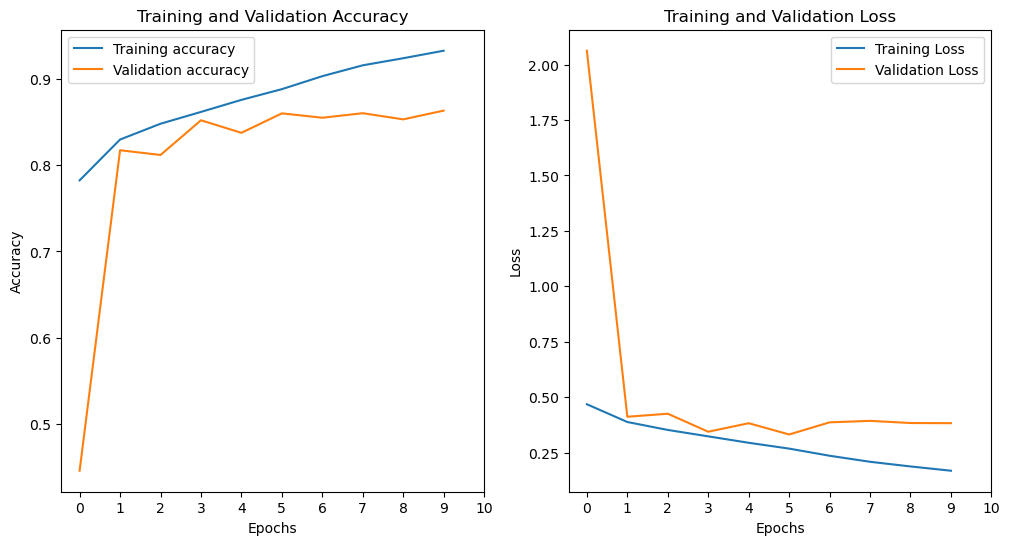

In [140]:
plot_history(history_en)

In [146]:
predict_test(model_en, 'data/my_submission_en.csv')

575/575 [==============================] - 21s 36ms/step


Kaggle score is 0.7377.

EfficientNet, despite its advanced architecture, did not perform as well as expected. The model's metrics are slightly below those of the Standard CNN model, indicating potential overfitting or the necessity for further tuning and regularization.

Training and Validation:
The model showed a consistent increase in training accuracy over the epochs, reaching up to 0.9326, but the validation accuracy fluctuated, reaching a maximum of 0.8632. This suggests that the model might be overfitting to the training data and failing to generalize well to unseen data.

## 4.3 EfficientNet with parameter tuning

In [142]:
model_metrics(model_en_tune)

177/177 [==============================] - 16s 85ms/step
Accuracy: 0.5259402340643109
Precision: 0.4068696235739125
Recall: 0.3744946091644205
F1 Score: 0.3900114038422176
ROC-AUC: 0.5029544484648267


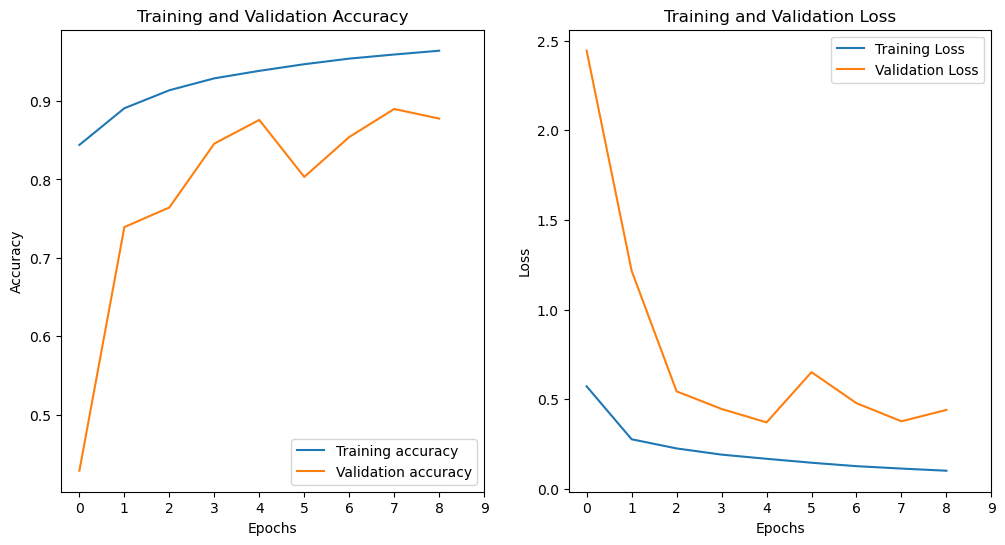

In [143]:
plot_history(history_en_tune)

In [145]:
predict_test(model_en_tune, 'data/my_submission_en_tune.csv')

575/575 [==============================] - 234s 407ms/step


Kaggle score is 0.7573.

The EfficientNet model with parameter tuning and regularization techniques exhibited a similar performance to the previous models. The additional parameter tuning and regularization did not significantly improve the model's performance in terms of the evaluated metrics.

Training and Validation:
The model, with added regularization and early stopping, demonstrated a substantial increase in training accuracy, achieving up to 0.9643. However, the validation accuracy reached a maximum of 0.8899, indicating a potential disparity between training and validation performance, suggesting overfitting.

## 4.4 Analysis

All three models showed success in classifying histopathologic cancer images. Surprisingly, the standard CNN outperformed the EfficientNet models on this dataset, Despite the advantages of EfficientNet models, they did not substantially surpass the standard model in this training dataset, potentially due to overfitting.

We submitted the predictions to Kaggle, the scores are as follows, the models are not well performing to unseen data.

- Standard CNN: 0.7676
- EfficientNet: 0.7377
- EfficientNet with Tuning: 0.7573


Despite achieving good accuracy on the training dataset, the models did not show good performance on the test dataset, suggesting a possible overfitting to the training data and there is a room for improvement.

# Step 5 : Conclusion

We assessed three  models in this project, achieved a certain level of performance in classifying histopathologic cancer images. The standard CNN interestingly showed the good performance among the EfficientNet models while expecting EfficientNet models are more capable.

In future work, a deeper exploration into more advanced tuning methods and hyperparameter optimizations is important. Additionally, exploring the incorporation of external pre-trained models with EfficientNet can be our success. Pre-trained models, which are trained on extensive and diverse datasets, are expected to encapsulate a richer understanding of features, potentially leading to enhanced feature extraction and, consequently, improved model performance. These models, having learned a wide array of features from their training on extensive datasets, can potentially generalize better to unseen data, aiding in mitigating overfitting and enhancing the model's predictive accuracy.

Moreover, experimenting with different architectures, employing advanced regularization techniques, and leveraging ensemble methods could further augment the performance of our models, providing more nuanced and generalized predictions in detecting histopathologic cancer.

# Reference
- https://www.kaggle.com/discussions/getting-started/149448
- https://www.tensorflow.org/tutorials/images/cnn
- https://keras.io/examples/nlp/active_learning_review_classification/